<a href="https://colab.research.google.com/github/DS4SD/docling/blob/main/docs/examples/rag_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG with LangChain

| Step | Tech | Execution | 
| --- | --- | --- |
| Embedding | Hugging Face / Sentence Transformers | 💻 Local |
| Vector store | Milvus | 💻 Local |
| Gen AI | Hugging Face Inference API | 🌐 Remote | 

This example leverages the
[LangChain Docling integration](../../integrations/langchain/), along with a Milvus
vector store, as well as sentence-transformers embeddings.

The presented `DoclingLoader` component enables you to:
- use various document types in your LLM applications with ease and speed, and
- leverage Docling's rich format for advanced, document-native grounding.

`DoclingLoader` supports two different export modes:
- `ExportType.MARKDOWN`: if you want to capture each input document as a separate
  LangChain document, or
- `ExportType.DOC_CHUNKS` (default): if you want to have each input document chunked and
  to then capture each individual chunk as a separate LangChain document downstream.

The example allows exploring both modes via parameter `EXPORT_TYPE`; depending on the
value set, the example pipeline is then set up accordingly.

## Setup

- 👉 For best conversion speed, use GPU acceleration whenever available; e.g. if running on Colab, use GPU-enabled runtime.
- Notebook uses HuggingFace's Inference API; for increased LLM quota, token can be provided via env var `HF_TOKEN`.
- Requirements can be installed as shown below (`--no-warn-conflicts` meant for Colab's pre-populated Python env; feel free to remove for stricter usage):

In [1]:
%pip install -q --progress-bar off --no-warn-conflicts langchain-docling langchain-core langchain-huggingface langchain_milvus langchain matplotlib python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path
from tempfile import mkdtemp

from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_docling.loader import ExportType


def _get_env_from_colab_or_os(key):
    try:
        from google.colab import userdata

        try:
            return userdata.get(key)
        except userdata.SecretNotFoundError:
            pass
    except ImportError:
        pass
    return os.getenv(key)


load_dotenv()

# https://github.com/huggingface/transformers/issues/5486:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

HF_TOKEN = _get_env_from_colab_or_os("HF_TOKEN")
SOURCES = ["https://arxiv.org/pdf/2408.09869"]  # Docling Technical Report
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
GEN_MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1"
EXPORT_TYPE = ExportType.DOC_CHUNKS
QUESTION = "Which are the main AI models in Docling?"
PROMPT = PromptTemplate.from_template(
    "Context information is below.\n---------------------\n{context}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {input}\nAnswer:\n",
)
TOP_K = 3
MILVUS_URI = str(Path(mkdtemp()) / "docling.db")

## Document store setup



## Document loading

We first define our converter, in this case including options for keeping page images (for visual grounding).

In [3]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=PdfPipelineOptions(
                generate_page_images=True,
                images_scale=2.0,
            ),
        )
    }
)

We set up a simple doc store for keeping converted documents, as that is needed for visual grounding further below.

In [4]:
doc_store = {}
doc_store_root = Path(mkdtemp())
for source in SOURCES:
    dl_doc = converter.convert(source=source).document
    file_path = Path(doc_store_root / f"{dl_doc.origin.binary_hash}.json")
    dl_doc.save_as_json(file_path)
    doc_store[dl_doc.origin.binary_hash] = file_path

Now we can instantiate our loader and load documents.

In [5]:
from langchain_docling import DoclingLoader

from docling.chunking import HybridChunker

loader = DoclingLoader(
    file_path=SOURCES,
    converter=converter,
    export_type=EXPORT_TYPE,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


> 👉 **NOTE**: As you see above, using the `HybridChunker` can sometimes lead to a warning from the transformers library, however this is a "false alarm" — for details check [here](https://ds4sd.github.io/docling/faq/#hybridchunker-triggers-warning-token-indices-sequence-length-is-longer-than-the-specified-maximum-sequence-length-for-this-model).

Determining the splits:

In [6]:
if EXPORT_TYPE == ExportType.DOC_CHUNKS:
    splits = docs
elif EXPORT_TYPE == ExportType.MARKDOWN:
    from langchain_text_splitters import MarkdownHeaderTextSplitter

    splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3"),
        ],
    )
    splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]
else:
    raise ValueError(f"Unexpected export type: {EXPORT_TYPE}")

Inspecting some sample splits:

In [7]:
for d in splits[:3]:
    print(f"- {d.page_content=}")
print("...")

- d.page_content='Docling Technical Report\nVersion 1.0\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar\nAI4K Group, IBM Research R¨ uschlikon, Switzerland'
- d.page_content='Abstract\nThis technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.'
- d.page_content='1 Introduction\nConverting PDF documents back into a machine-processable format has been a major challenge for deca

## Ingestion

In [8]:
import json
from pathlib import Path
from tempfile import mkdtemp

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_milvus import Milvus

embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)


milvus_uri = str(Path(mkdtemp()) / "docling.db")  # or set as needed
vectorstore = Milvus.from_documents(
    documents=splits,
    embedding=embedding,
    collection_name="docling_demo",
    connection_args={"uri": milvus_uri},
    index_params={"index_type": "FLAT"},
    drop_old=True,
)

## RAG

In [9]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFaceEndpoint

retriever = vectorstore.as_retriever(search_kwargs={"k": TOP_K})
llm = HuggingFaceEndpoint(
    repo_id=GEN_MODEL_ID,
    huggingfacehub_api_token=HF_TOKEN,
)


def clip_text(text, threshold=100):
    return f"{text[:threshold]}..." if len(text) > threshold else text

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
from docling.chunking import DocMeta
from docling.datamodel.document import DoclingDocument

question_answer_chain = create_stuff_documents_chain(llm, PROMPT)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
resp_dict = rag_chain.invoke({"input": QUESTION})

clipped_answer = clip_text(resp_dict["answer"], threshold=200)
print(f"Question:\n{resp_dict['input']}\n\nAnswer:\n{clipped_answer}")

/Users/pva/work/github.com/DS4SD/docling/.venv/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Question:
Which are the main AI models in Docling?

Answer:
The main AI models in Docling are a layout analysis model, an accurate object-detector for page elements, and TableFormer, a state-of-the-art table structure recognition model.


### Grounding

Source 1:
  text: "3.2 AI models\nAs part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure re..."
  page: 3


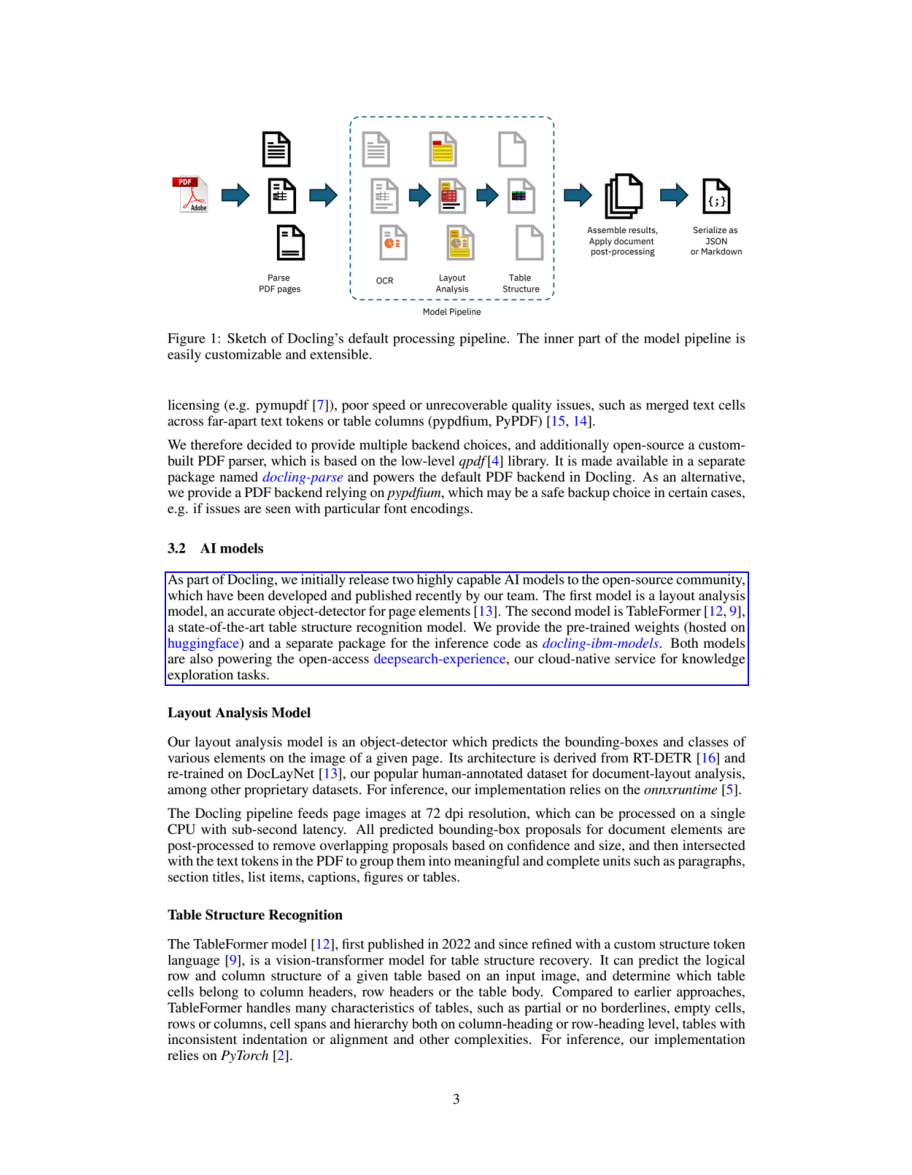

Source 2:
  text: "3 Processing pipeline\nDocling implements a linear pipeline of operations, which execute sequentially on each given document (see Fig. 1). Each document is first parsed by a PDF backend, which retrieves the programmatic text tokens, consisting of string content and its coordinates on the page, and also renders a bitmap image of each page to support ..."
  page: 2


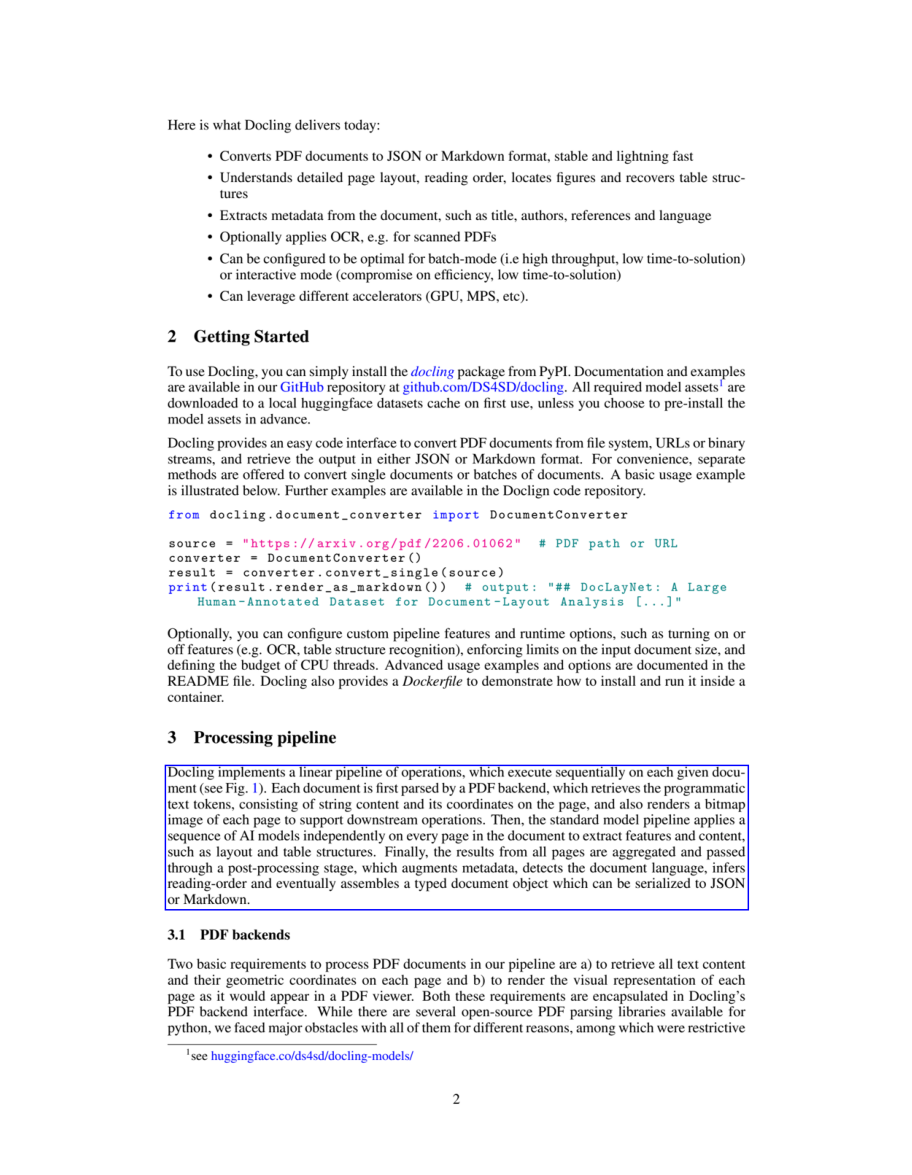

Source 3:
  text: "6 Future work and contributions\nDocling is designed to allow easy extension of the model library and pipelines. In the future, we plan to extend Docling with several more models, such as a figure-classifier model, an equationrecognition model, a code-recognition model and more. This will help improve the quality of conversion for specific types of ..."
  page: 5


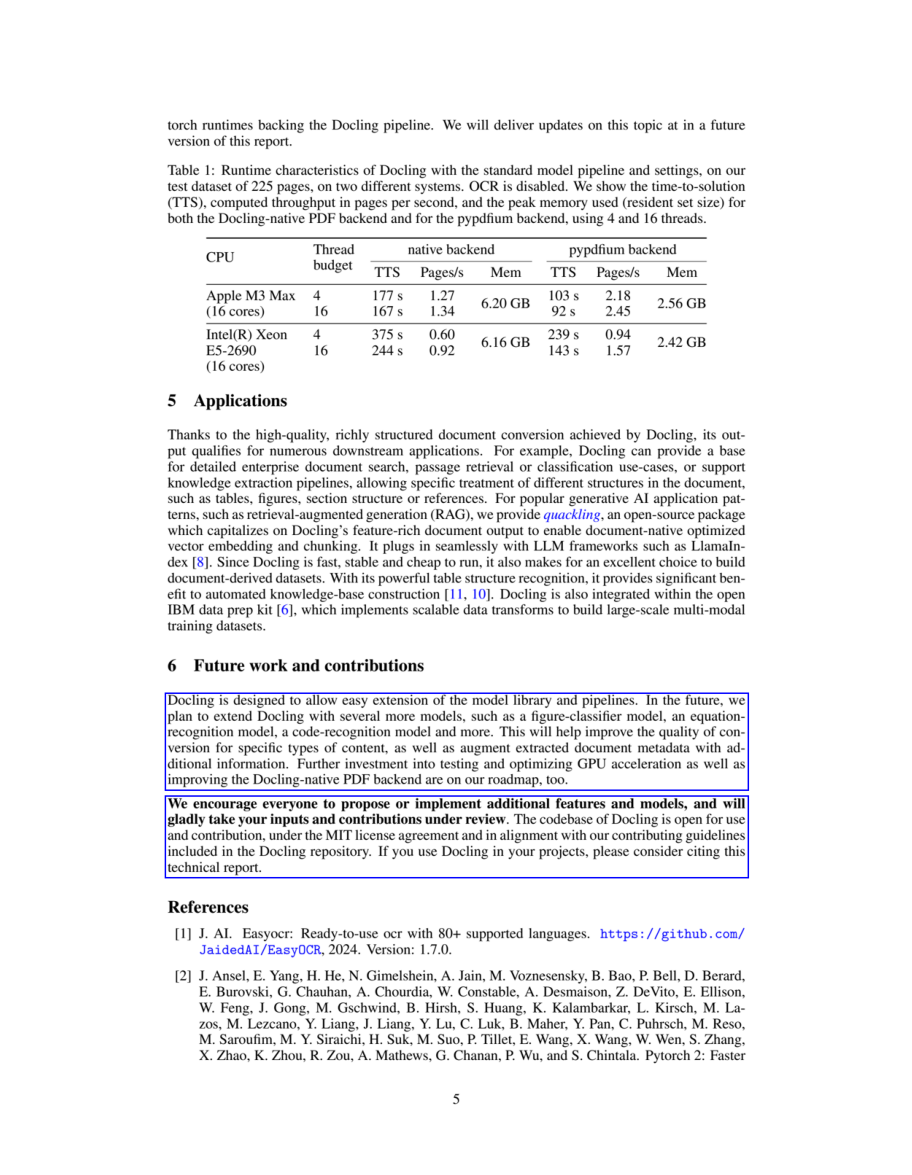

In [11]:
import matplotlib.pyplot as plt
from PIL import ImageDraw

for i, doc in enumerate(resp_dict["context"][:]):
    image_by_page = {}
    print(f"Source {i+1}:")
    print(f"  text: {json.dumps(clip_text(doc.page_content, threshold=350))}")
    meta = DocMeta.model_validate(doc.metadata["dl_meta"])
    dl_doc = DoclingDocument.load_from_json(doc_store.get(meta.origin.binary_hash))
    for doc_item in meta.doc_items:
        prov = doc_item.prov[0]
        page_no = prov.page_no
        if img := image_by_page.get(page_no):
            pass
        else:
            page = dl_doc.pages[prov.page_no]
            print(f"  page: {prov.page_no}")
            img = page.image.pil_image
            image_by_page[page_no] = img
        bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
        bbox = bbox.normalized(page.size)
        thickness = 2
        padding = thickness + 2
        bbox.l = round(bbox.l * img.width - padding)
        bbox.r = round(bbox.r * img.width + padding)
        bbox.t = round(bbox.t * img.height - padding)
        bbox.b = round(bbox.b * img.height + padding)
        draw = ImageDraw.Draw(img)
        draw.rectangle(
            xy=bbox.as_tuple(),
            outline="blue",
            width=thickness,
        )
    for p in image_by_page:
        img = image_by_page[p]
        plt.figure(figsize=[15, 15])
        plt.imshow(img)
        plt.axis("off")
        plt.show()